# 3.4 利用Q學習控制CartPole

<img src='https://pic1.xuehuaimg.com/proxy/csdn/https://img-blog.csdn.net/20170822173609707?watermark/2/text/aHR0cDovL2Jsb2cuY3Nkbi5uZXQvY3Vpd2FkZXI=/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70/gravity/SouthEast'>




# **Run gym on the Google Colab**

rvised by andy, 2020-05-17

In [1]:
# Andy 

#installing dependencies
!apt-get -qq -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1 > /dev/null
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!apt-get install x11-utils
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!pip -q install gym
!pip -q install pyglet
!pip -q install pyopengl
!pip -q install pyvirtualdisplay

E: Unable to locate package libcusparse8.0
E: Couldn't find any package by glob 'libcusparse8.0'
E: Couldn't find any package by regex 'libcusparse8.0'
E: Unable to locate package libnvrtc8.0
E: Couldn't find any package by glob 'libnvrtc8.0'
E: Couldn't find any package by regex 'libnvrtc8.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils
0 upgraded, 2 newly installed, 0 to remove and 31 not upgraded.
Need to get 209 kB of archives.
After this operation, 711 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Fetched 209 kB in 1s (227 kB/s)
Selecting previously unselected package libxxf86dga

In [0]:
# Andy
import gym
import numpy as np

In [0]:
# Andy
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML

# re-define the function display_frames_as_gif by Andy 2020-05-17
# to be ran on the Google Colabollation

def display_frames_as_gif(frames):

    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    animate = lambda i: patch.set_data(frames[i])
    ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
    HTML(ani.to_jshtml())


In [0]:
# 常數的設定
ENV = 'CartPole-v0'  # 使用的課題名稱
NUM_DIZITIZED = 6  # 各狀態的離散值分割數
GAMMA = 0.99  # 時間折扣率
ETA = 0.5  # 學習係數
MAX_STEPS = 200  # 單回合的step數
NUM_EPISODES = 1000  # 最大回合數


In [0]:
class Agent:
    '''這是CartPole的智能體類別、代表的是立有棒子的推車'''

    def __init__(self, num_states, num_actions):
        self.brain = Brain(num_states, num_actions)  # 為了讓代理器決定動作而建置頭腦

    def update_Q_function(self, observation, action, reward, observation_next):
        '''Q函數的更新'''
        self.brain.update_Q_table(
            observation, action, reward, observation_next)

    def get_action(self, observation, step):
        '''決定動作'''
        action = self.brain.decide_action(observation, step)
        return action
    

In [0]:
class Brain:
    '''智能體的腦袋類別，會於此類別執行Q學習'''

    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions  # 取得CartPole的動作（向右或向左）的2

        # 建立Q table。列數為狀態轉換成分割數^（4個變數)的離散值、欄數為動作數量
        self.q_table = np.random.uniform(low=0, high=1, size=(
            NUM_DIZITIZED**num_states, num_actions))


    def bins(self, clip_min, clip_max, num):
        '''計算觀測所得的狀態（連續值)轉換成離散值的臨界值'''
        return np.linspace(clip_min, clip_max, num + 1)[1:-1]

    def digitize_state(self, observation):
        '''將觀測所得的observation狀態轉換成離散值'''
        cart_pos, cart_v, pole_angle, pole_v = observation
        digitized = [
            np.digitize(cart_pos, bins=self.bins(-2.4, 2.4, NUM_DIZITIZED)),
            np.digitize(cart_v, bins=self.bins(-3.0, 3.0, NUM_DIZITIZED)),
            np.digitize(pole_angle, bins=self.bins(-0.5, 0.5, NUM_DIZITIZED)),
            np.digitize(pole_v, bins=self.bins(-2.0, 2.0, NUM_DIZITIZED))
        ]
        return sum([x * (NUM_DIZITIZED**i) for i, x in enumerate(digitized)])

    def update_Q_table(self, observation, action, reward, observation_next):
        '''以Q學習更新Q table'''
        state = self.digitize_state(observation)  # 將狀態轉換成離散值
        state_next = self.digitize_state(observation_next)  # 將下一個狀態轉換成離散值
        Max_Q_next = max(self.q_table[state_next][:])
        self.q_table[state, action] = self.q_table[state, action] + \
            ETA * (reward + GAMMA * Max_Q_next - self.q_table[state, action])

    def decide_action(self, observation, episode):
        '''以ε-greedy法篩減動作，直到最後只採行最佳的動作'''
        state = self.digitize_state(observation)
        epsilon = 0.5 * (1 / (episode + 1))

        if epsilon <= np.random.uniform(0, 1):
            action = np.argmax(self.q_table[state][:])
        else:
            action = np.random.choice(self.num_actions)  # 隨機傳回0,1的動作
        return action
    

##v1

In [0]:
class Environment:
    '''這是執行CartPole的環境類別'''

    def __init__(self):
        self.env = gym.make(ENV)  # 設定要執行的課題
        num_states = self.env.observation_space.shape[0]  # 取得課題的狀態數4
        num_actions = self.env.action_space.n  # 取得CartPole的動作（向右或向左）的2
        self.agent = Agent(num_states, num_actions)  # 於環境建立採行動作的Agent

    def run(self):

        '''執行'''
        complete_episodes = 0  # 連續執行195step以上的回合數
        is_episode_final = False  # 最終回合的旗標
        frames = []  # 儲存影像，供製作動畫之用的變數

        for episode in range(NUM_EPISODES):  # 重覆執行，直到設定的回合數為止
            observation = self.env.reset()  # 初始化環境

            for step in range(MAX_STEPS):  # 1回合的迴圈

                if is_episode_final is True:  # 於最終回合將各時刻的影像存入frames
                    frames.append(self.env.render(mode='rgb_array'))
                    print('frames len =', len(frames))

                # 求出動作
                action = self.agent.get_action(observation, episode)

                # 執行動作a_t、算出s_{t+1}, r_{t+1}
                observation_next, _, done, _ = self.env.step(
                    action)  # 由於不會用到reward與info所以設定為_

                # 給予報酬
                if done:  # Step數超過200或棒子傾斜至一定角度時，done將為true
                    if step < 195:
                        reward = -1  # 中途棒子傾倒的話，將以報酬-1作為罰則
                        complete_episodes = 0  # 連續195step之後，重設回合數
                    else:
                        reward = 1  # 若棒子依然直立，給予報酬1
                        complete_episodes += 1  # 更新連續記錄
                else:
                    reward = 0  # 中途的報酬為0

                # 以step+1的狀態observation_next更新Q函數
                self.agent.update_Q_function(
                    observation, action, reward, observation_next)

                # 觀測的更新
                observation = observation_next

                # 結束時的處理
                if done:
                    print('{0} Episode: Finished after {1} time steps'.format(
                        episode, step + 1))
                    break

            if is_episode_final is True:  # 於最終回合儲存與繪製動畫
                #display_frames_as_gif(frames)
                break

            if complete_episodes >= 10:  # 連續10回合成功的話
                print('連續10回合成功')
                is_episode_final = True  # 將下回合視為繪製動畫的最終回合

        return frames                

In [0]:
# Start virtual display
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

In [11]:
# main
cartpole_env = Environment()
frames = cartpole_env.run()


0 Episode: Finished after 14 time steps
1 Episode: Finished after 18 time steps
2 Episode: Finished after 19 time steps
3 Episode: Finished after 107 time steps
4 Episode: Finished after 18 time steps
5 Episode: Finished after 16 time steps
6 Episode: Finished after 10 time steps
7 Episode: Finished after 9 time steps
8 Episode: Finished after 13 time steps
9 Episode: Finished after 15 time steps
10 Episode: Finished after 12 time steps
11 Episode: Finished after 11 time steps
12 Episode: Finished after 13 time steps
13 Episode: Finished after 21 time steps
14 Episode: Finished after 10 time steps
15 Episode: Finished after 10 time steps
16 Episode: Finished after 18 time steps
17 Episode: Finished after 23 time steps
18 Episode: Finished after 31 time steps
19 Episode: Finished after 62 time steps
20 Episode: Finished after 50 time steps
21 Episode: Finished after 49 time steps
22 Episode: Finished after 10 time steps
23 Episode: Finished after 56 time steps
24 Episode: Finished after

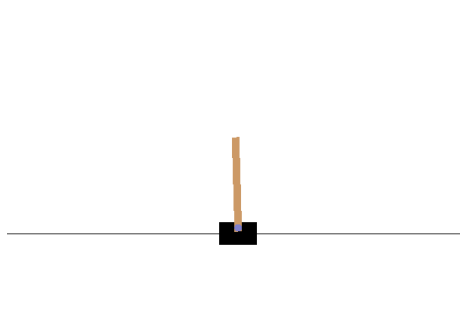

In [12]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML

# re-define the function display_frames_as_gif by Andy 2020-05-17
# to be ran on the Google Colabollation

plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())

##v2

** Andy Revised**

In [0]:
# Start virtual display
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)


In [0]:
# Environemt Executor

env = gym.make(ENV)  # 設定要執行的課題
num_states = env.observation_space.shape[0]  # 取得課題的狀態數4
num_actions = env.action_space.n  # 取得CartPole的動作（向右或向左）的2
agent = Agent(num_states, num_actions)  # 於環境建立採行動作的Agent

print('num_states', num_states) # Andy Add
print('num_actions', num_actions) # Andy Add

'''執行'''
complete_episodes = 0  # 連續執行195step以上的回合數
is_episode_final = False  # 最終回合的旗標
frames = []  # 儲存影像，供製作動畫之用的變數

for episode in range(NUM_EPISODES):  # 重覆執行，直到設定的回合數為止
    observation = env.reset()  # 初始化環境
    #print('initial observation:', observation) # Andy Add

    for step in range(MAX_STEPS):  # 1回合的迴圈

        if is_episode_final is True:  # 於最終回合將各時刻的影像存入frames
           frames.append(env.render(mode='rgb_array'))
           print('frames len =', len(frames))

        # 求出動作
        action = agent.get_action(observation, episode)

        # 執行動作a_t、算出s_{t+1}, r_{t+1}
        observation_next, _, done, _ = env.step(
                    action)  # 由於不會用到reward與info所以設定為_

        # 給予報酬
        if done:  # Step數超過200或棒子傾斜至一定角度時，done將為true
            if step < 195:
               reward = -1  # 中途棒子傾倒的話，將以報酬-1作為罰則
               complete_episodes = 0  # 連續195step之後，重設回合
            else:
               reward = 1  # 若棒子依然直立，給予報酬1
               complete_episodes += 1  # 更新連續記錄
        else:
            reward = 0  # 中途的報酬為0

        # 以step+1的狀態observation_next更新Q函數
        agent.update_Q_function(
            observation, action, reward, observation_next)

        # 觀測的更新
        observation = observation_next

        # 結束時的處理
        if done:
            print('{0} Episode: Finished after {1} time steps'.format(
                  episode, step + 1), 'done = ', done)
            break

        if is_episode_final is True:  # 於最終回合儲存與繪製動畫
            #display_frames_as_gif(frames)
            break

        if complete_episodes >= 10:  # 連續10回合成功的話
            print('連續10回合成功')
            is_episode_final = True  # 將下回合視為繪製動畫的最終回合



In [0]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML

# re-define the function display_frames_as_gif by Andy 2020-05-17
# to be ran on the Google Colabollation

plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())